## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
#from get_data import unpack
#unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [2]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from pandas import read_csv
import numpy as np
import glob
from imgaug import augmenters as iaa

def load_imgs_and_keypoints(dirname='facial-keypoints'):
    
    points = read_csv('/home/vlad/Documents/facial-keypoints/data/gt.csv')
    points = points.values
    files = points[:,0]
    points = points[:,1:]

    imgs = np.empty((6000,100,100,3))
    pts = np.empty((6000,28))
    i = 0
    
    for filename in files:

        im = imread(join('/home/vlad/Documents/facial-keypoints/data/images/', filename))
        
        h = im.shape[0]
        w = im.shape[1]
        
        x = points[i][0::2]
        x = x/w - 0.5
        y = points[i][1::2]
        y = y/h - 0.5
        pts[i,:] = np.ravel([x,y], 'F')
        
        im = resize(im, (100,100))
        if im.shape[-1] != 3:
            im = gray2rgb(im)
        im = np.expand_dims(im, axis = 0)
        imgs[i,:,:,:] = im
        i += 1    
   
    return imgs, pts
        
imgs, points = load_imgs_and_keypoints()

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

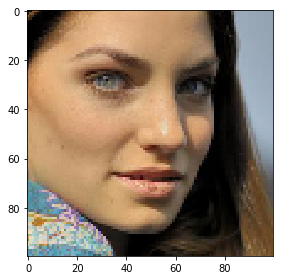

In [3]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


array([-0.27659574, -0.28723404, -0.11702128, -0.30851064,  0.10638298,
       -0.29787234,  0.35106383, -0.23404255, -0.25531915, -0.21276596,
       -0.13829787, -0.22340426, -0.07446809, -0.20212766,  0.12765957,
       -0.18085106,  0.22340426, -0.18085106,  0.32978723, -0.14893617,
       -0.04255319, -0.0106383 , -0.17021277,  0.14893617, -0.0212766 ,
        0.20212766,  0.13829787,  0.19148936])

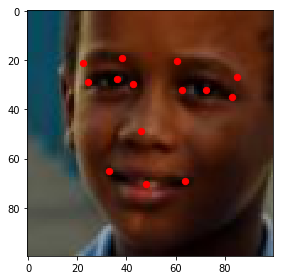

In [4]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    
    x = []
    y = []

    for i in range(0, points.shape[0], 2):
        x.append(np.multiply(np.add(points[i], 0.5), 100))
        y.append(np.multiply(np.add(points[i+1], 0.5), 100))

    imshow(img)
    plt.scatter(x=x, y=y, c='r', s=40)
    
visualize_points(imgs[1], points[1])
points[1]

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


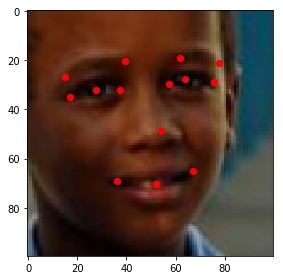

In [6]:
def flip_img(img, points):
    # Write your code for flipping here
    
    swap_dict = {0:6,1:7,2:4,3:5,8:18,9:19,10:16,11:17,12:14,13:15,22:26,23:27}
    
    f_img = np.fliplr(img)
        
    mask = np.resize([-1,1], 28) 
    f_points = np.multiply(points, mask)
        
    for i in range(len(f_points)):
        if i in swap_dict:
            temp = f_points[i]
            f_points[i] = f_points[swap_dict[i]]
            f_points[swap_dict[i]] = temp

    return f_img, f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)


            
            

In [7]:
imgs_train.shape

(5400, 100, 100, 3)

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


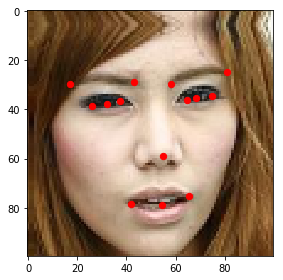

In [8]:
import cv2
from random import randint

def shift_img(img, points):
    
    rows,cols,_ = img.shape
    shift_h = randint(-10,10) #-10,10
    shift_v = randint(-10,20) #-15,25
    M = np.float32([[1,0,shift_h],[0,1,shift_v]])
    f_img = cv2.warpAffine(img,M,(cols,rows), borderMode = cv2.BORDER_REFLECT)

    f_points = np.empty((28,))
    f_points[::2] = shift_h / 100 + points[::2]
    f_points[1::2] = shift_v / 100 + points[1::2]
        
    return f_img, f_points

i = randint(0,len(imgs_train))
f_img, f_points = shift_img(imgs[i], points[i])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [9]:
# Write your code here
from sklearn.utils import shuffle

def build_augmented_set(images, points):
    
    aug_imgs = np.empty((len(images)*2,100,100,3))
    aug_points = np.empty((len(images)*2,28))

    j = 0
    for i in range(points.shape[0]):

        img = images[i,:,:,:]
        line = points[i,:] 
        aug_imgs[j,:,:,:] = img
        aug_points[j,:] = line

        j +=1

        f_img, f_line = flip_img(img, line)
        aug_imgs[j,:,:,:] = f_img
        aug_points[j,:] = f_line

        j += 1

    aug_imgs, aug_points = shuffle(aug_imgs, aug_points)
    
    return aug_imgs, aug_points


aug_imgs_train, aug_points_train = build_augmented_set(imgs_train, points_train)
aug_imgs_val, aug_points_val = build_augmented_set(imgs_val, points_val)



/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


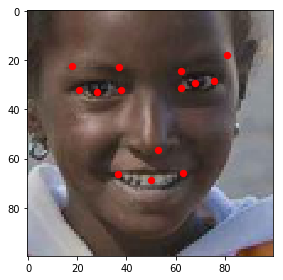

In [10]:

i = randint(0,len(aug_imgs_train))
visualize_points(aug_imgs_train[i], aug_points_train[i])

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


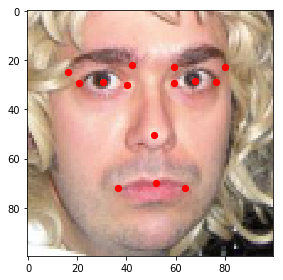

In [11]:
i = 1018
visualize_points(aug_imgs_train[i], aug_points_train[i])

In [13]:
def generator(aug_imgs, aug_points, batch_size=32):
    '''
    In addition to flipping the images, random shifting them proved critical to good model performance.
    I tried a few methods from imgaug library, but the simple shifting routine worked better for me
    '''
    #create empty array
    batch_imgs = np.zeros((batch_size,100,100,3))
    batch_points = np.zeros((batch_size,28))

    while True:
        for i in range(batch_size):
            index = np.random.choice(aug_imgs.shape[0],1)    
            batch_imgs[i], batch_points[i] = shift_img(np.squeeze(aug_imgs[index]), np.squeeze(aug_points[index]))
                
        yield batch_imgs, batch_points


### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [20]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout)

model = Sequential()
    
model.add(Conv2D(32, (4, 4), strides = (1, 1), activation='relu', padding='same', input_shape=(100,100,3)))
model.add(MaxPooling2D((2,2)))
    
model.add(Conv2D(64, (4, 4), strides = (1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
    
model.add(Conv2D(128, (5, 5), strides = (1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(28))


# Define here your model

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      1568      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        32832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [22]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
BATCH_SIZE = 32
NUM_EPOCHS = 100

#model.compile(loss='mean_squared_error', optimizer = Adam(lr=0.001, decay = 0.05))
learning_rate = 0.2

#use 100 or number of epochs as denominator; with a smaller number of epochs decay is too rapid
decay_rate = learning_rate / 100

#model.compile(loss='mean_squared_error', optimizer = SGD(lr=learning_rate, momentum = 0.8, decay=decay_rate, nesterov=False))
model.compile(loss='mean_squared_error', optimizer = Adam())

train_num_batches = len(aug_imgs_train) // BATCH_SIZE
test_num_batches = len(aug_imgs_val) // BATCH_SIZE

checkpointer = ModelCheckpoint(filepath='/home/vlad/Documents/facial-keypoints/weights.hdf5',
                                       verbose=0, save_best_only=True)

train_gen = generator(aug_imgs_train, aug_points_train, batch_size=BATCH_SIZE)

model.fit_generator(generator=train_gen, epochs=NUM_EPOCHS, verbose=1, validation_data=(aug_imgs_val, aug_points_val),
                    samples_per_epoch=200, callbacks=[checkpointer])

/home/vlad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., epochs=100, verbose=1, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=200)`


Epoch 1/100
200/200 [==============================] - 4s 19ms/step - loss: 0.0115 - val_loss: 0.0040
Epoch 2/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 3/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 6/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/100
200/200 [==============================] - 4s 18ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 9/100
200/200 [==============================] - 4s 18ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/100
200/200 [==============================] - 4s 18ms/step - loss: 0.002

### Visualize results

In [29]:
#model.save('/home/vlad/Documents/facial-keypoints/keypoints_model.h5')
model.load_weights(filepath='/home/vlad/Documents/facial-keypoints/weights.hdf5')

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[-0.24901262 -0.27280605 -0.05515907 -0.26335368  0.16571188 -0.24733421
  0.3703352  -0.22071034 -0.20918451 -0.17718606 -0.13531274 -0.17563926
 -0.06230859 -0.16257189  0.16778201 -0.1501671   0.23989794 -0.15213966
  0.3181831  -0.14215067  0.03072876  0.0539319  -0.11740331  0.20506299
  0.02199007  0.22716552  0.1724974   0.22662935]


/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


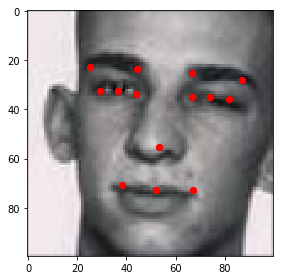

In [30]:

img = imgs_val[0]
pts = points_val[0]

predict_pts = model.predict(np.expand_dims(img, axis=0))
predict_pts = np.squeeze(predict_pts)

#print(pts)
print(predict_pts)

#del(predict_pts)
# Example of output
visualize_points(img, predict_pts)

[-0.30220664 -0.25350454 -0.10614675 -0.26110983  0.10513425 -0.27222705
  0.30929857 -0.27834582 -0.25293547 -0.16587833 -0.17570218 -0.17183654
 -0.10236123 -0.16721451  0.11797886 -0.17871448  0.19054107 -0.1916585
  0.2665097  -0.19029701  0.01423577  0.03465152 -0.11611549  0.19846353
  0.0232578   0.20331408  0.16817158  0.18714552]


/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


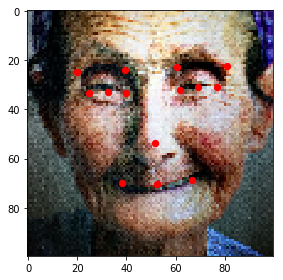

In [31]:
img = imgs_val[1]
pts = points_val[1]

predict_pts = model.predict(np.expand_dims(img, axis=0))
predict_pts = np.squeeze(predict_pts)

#print(pts)
print(predict_pts)

# Example of output
visualize_points(img, predict_pts)

[-0.25331125 -0.33035916 -0.05733175 -0.30240315  0.15953818 -0.2750299
  0.3576866  -0.2385295  -0.2215915  -0.23449528 -0.14633462 -0.22807446
 -0.0724096  -0.20823225  0.14948204 -0.18181714  0.21995044 -0.18101908
  0.29623428 -0.16598251  0.00774208  0.0158289  -0.15701702  0.14766182
 -0.01823886  0.18148369  0.13263321  0.18572226]


/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


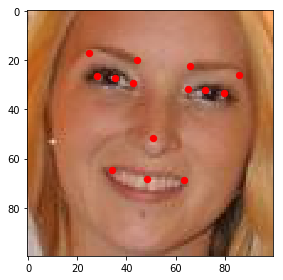

In [32]:
img = imgs_val[2]
pts = points_val[2]

predict_pts = model.predict(np.expand_dims(img, axis=0))
predict_pts = np.squeeze(predict_pts)

print(predict_pts)

# Example of output
visualize_points(img, predict_pts)

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


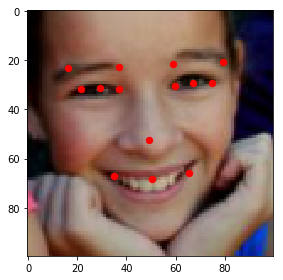

In [33]:
img = imgs_val[3]
pts = points_val[3]

predict_pts = model.predict(np.expand_dims(img, axis=0))
predict_pts = np.squeeze(predict_pts)

# Example of output
visualize_points(img, predict_pts)

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


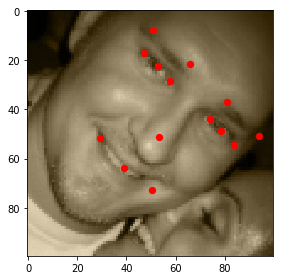

In [34]:
img = imgs_val[4]
pts = points_val[4]

predict_pts = model.predict(np.expand_dims(img, axis=0))
predict_pts = np.squeeze(predict_pts)

# Example of output
visualize_points(img, predict_pts)

/home/vlad/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


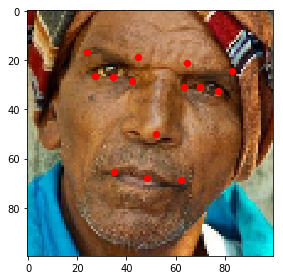

In [35]:
img = imgs_val[5]
pts = points_val[5]

predict_pts = model.predict(np.expand_dims(img, axis=0))
predict_pts = np.squeeze(predict_pts)

# Example of output
visualize_points(img, predict_pts)